In [1]:
import bpmfwfft.grids
import bpmfwfft.IO
import netCDF4 as nc
import numpy as np
import os.path

In [2]:
import csv
import pickle as p 
file_name = '/media/jim/Research_TWO/FFT_PPI/1.data_prep/1.affinity_database/affinity_combined.csv'
affinity_bm = {}
with open(file_name) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter='\t')
    line_count = 0
    labels = []
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
            labels = row
        else:
            props = {}
            props['dG'] = row[8]
            props['Kd'] = row[7]
            affinity_bm[row[0]] = props 
            
            line_count += 1
    print(f'Processed {line_count} lines.')

p.dump(affinity_bm, open( "/media/jim/Research_TWO/FFT_PPI/1.data_prep/1.affinity_database/affinity_bm.p", "wb" ))


Processed 180 lines.


In [4]:
from os import walk
import os


systems = []
for root, dirs, files in walk("/media/jim/Research_TWO/FFT_PPI/2.redock/4.receptor_grid", topdown=False):
   # for name in files:
   #    print(os.path.join(root, name))
    for name in dirs:
        # print(os.path.join(name))
        if name[0] != '.':
            systems.append(name)
systems.sort()

In [137]:
import pickle as p
import math

def get_close_to_native(native, trans_list):
    lmax = native.shape[0]
    d = 0.
    close = []
    for index, trans in enumerate(trans_list):
        for i in range(lmax):
            tmp = native[i] - trans[i]
            d += tmp*tmp
        if math.sqrt(d) < 2:
            close.append(index)       
    return close

native_translations = p.load( open( "/media/jim/Research_TWO/FFT_PPI/2.redock/4.receptor_grid/native_translations.p", "rb" ) )

    



In [51]:
print(native_translations.keys())

dict_keys(['crd', 'grid'])


In [ ]:
interaction_energy = []
delta_G = []
for system_name in systems:
    f = nc.Dataset(f'/media/jim/Research_TWO/FFT_PPI/2.redock/5.fft_sampling/{system_name}/fft_sample.nc')

    native_vectors_grid = f.variables['resampled_trans_vectors'][0]
    spacing = f.variables['spacing'][:]
    native_vectors_coord = native_vectors_grid*spacing
    native_lig_coord = f.variables['lig_positions'][0]
    
    # close_to_native_translations = get_close_to_native(native_translations[system_name]["grid"], native_vectors_grid)
    # lowest_energy_native_translation = f.variables['resampled_energies'][0][0]
    lowest_energy_native_translation = np.amin(f.variables['resampled_energies'])

    lig_prmtop = bpmfwfft.IO.PrmtopLoad(f'/media/jim/Research_TWO/FFT_PPI/2.redock/1.amber/{system_name}/ligand.prmtop')
    
    interaction_energy.append(lowest_energy_native_translation)
    delta_G.append(affinity_bm[system_name]['dG'])
    
    if not os.path.isdir(f'/media/jim/Research_TWO/FFT_PPI/2.redock/7.analysis/{system_name}'):
        os.mkdir(f'/media/jim/Research_TWO/FFT_PPI/2.redock/7.analysis/{system_name}')
#     for sample in close_to_native_translations:
#         interaction_energy.append(f.variables['resampled_energies'][0][sample])
#         delta_G.append(affinity_bm[system_name]['dG'])
    

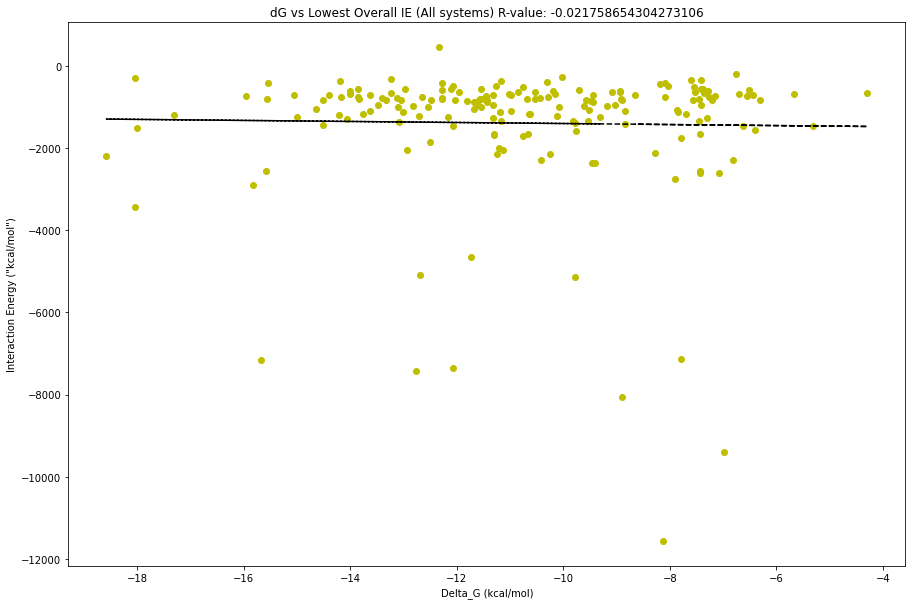

In [194]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = np.array(interaction_energy)
y = np.array(delta_G, dtype='float64')

# x[x>-600] = 0
# x[x<-10000] = 0

outliers = np.where(x == 0)
outliers = outliers[::-1]
    
for i in outliers:
    x = np.delete(x, i)
    y = np.delete(y, i)
    
ya = y
xa = x
y = xa
x = ya

reg = linregress(x,y)

coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y
fig, ax = plt.subplots()
m,b = np.polyfit(x, y, 1)
ax.plot(x,y, 'yo', x, poly1d_fn(x), '--k') #'--k'=black dashed line, 'yo' = yellow circle marker
ax.annotate("r-value = {:.3f}".format(reg[2]**2), (0, 1))

ax.set_title('dG vs Lowest Overall IE (All systems) R-value: ' + str(reg[2]))
ax.set_ylabel("Interaction Energy (\"kcal/mol\")")
ax.set_xlabel("Delta_G (kcal/mol)")

fig.set_figheight(10)
fig.set_figwidth(15)
plt.savefig("dGvsIE(lowestenergy_overall)_all.jpg", dpi=150)
plt.show()

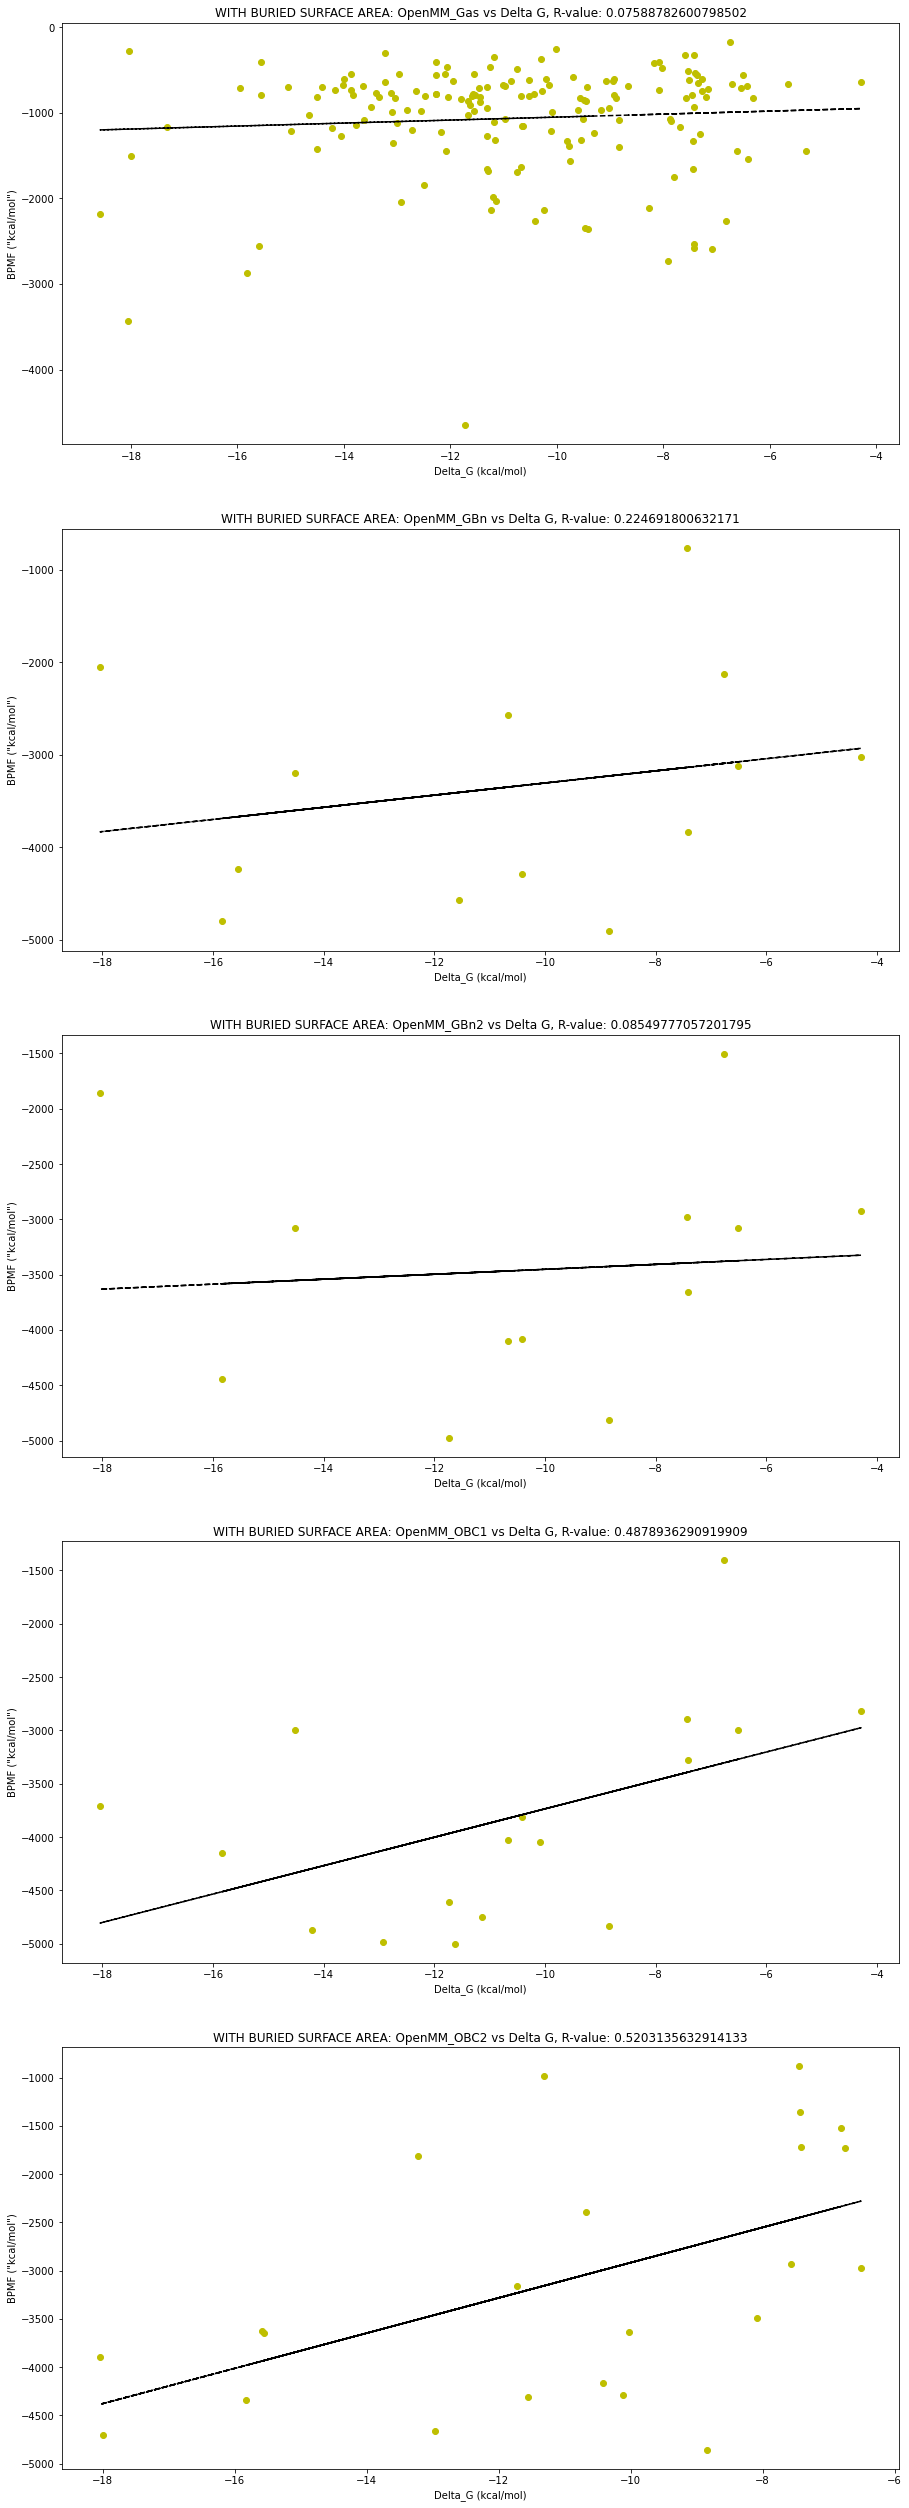

In [26]:
# BPMF vs Experimental Delta G
import pickle as p
import matplotlib.pyplot as plt
from scipy.stats import linregress
systems.sort()
models = ['OpenMM_Gas','OpenMM_GBn','OpenMM_GBn2','OpenMM_OBC1','OpenMM_OBC2']
affinity_bm = p.load( open( "/media/jim/Research_TWO/FFT_PPI/1.data_prep/1.affinity_database/affinity_bm.p", "rb" ))

bpmfs = {}
delta_G = []
for model in models:
    bpmfs[model] = []

for system_name in systems:
    try:
        # data = p.load( open(f'/media/jim/Research_TWO/OldData/6.postprocess/{system_name}/bpmf.pkl', 'rb'), encoding='latin1')
        data = p.load( open(f'/media/jim/Research_TWO/FFT_PPI/2.redock/6.postprocess/{system_name}/bpmf.pkl', 'rb'), encoding='latin1')
        for model in models:
            bpmfs[model].append(data['bpmf'][model])
        delta_G.append(affinity_bm[system_name]['dG'])
    except:
        print('failed loading file')
        for model in models:
            bpmfs[model].append(0)
        delta_G.append(affinity_bm[system_name]['dG'])

keys = list(bpmfs.keys())
ys = np.array(delta_G, dtype='float64')
fig, ax = plt.subplots(5,1)

fig.set_figheight(45)
fig.set_figwidth(15)

for key in range(len(keys)):
    
    x = np.array(bpmfs[keys[key]])
    # x[x<-1500] = 0
    # x[x>0] = 0
    # x[np.isnan(x)] = 0
    y = ys
        
    x = np.delete(x, 65)
    y = np.delete(y, 65)
    
    x = np.delete(x, 29)
    y = np.delete(y, 29)
    
    # x[x>0] = 0
    x[x<-5000] = 0
    
    outliers = np.where(x == 0)
    outliers = outliers[::-1]
    
    for i in outliers:
        x = np.delete(x, i)
        y = np.delete(y, i)
    
    ya = y
    xa = x
    y = xa
    x = ya
    
    # y[y<-2000] = 0
    # x[x>0] = 0
    # for j in range(len(x)):
    #     print(j, x[j], y[j])
    reg = linregress(x,y)

    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef) 
    # poly1d_fn is now a function which takes in x and returns an estimate for y
    
    m,b = np.polyfit(x, y, 1)
    ax[key].plot(x,y, 'yo', x, poly1d_fn(x), '--k') #'--k'=black dashed line, 'yo' = yellow circle marker
    ax[key].annotate("r-value = {:.3f}".format(reg[2]**2), (0, 1))
    ax[key].set_title(f'WITH BURIED SURFACE AREA: {keys[key]} vs Delta G, R-value: ' + str(reg[2]))
    ax[key].set_ylabel("BPMF (\"kcal/mol\")")
    ax[key].set_xlabel("Delta_G (kcal/mol)")
    extent = ax[key].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f"plots/dGvsBPMF_{models[key]}_5000cutoff.jpg", bbox_inches=extent.expanded(1.2, 1.2))


# plt.savefig("dGvsBPMF_all.jpg", dpi=150)
plt.show()

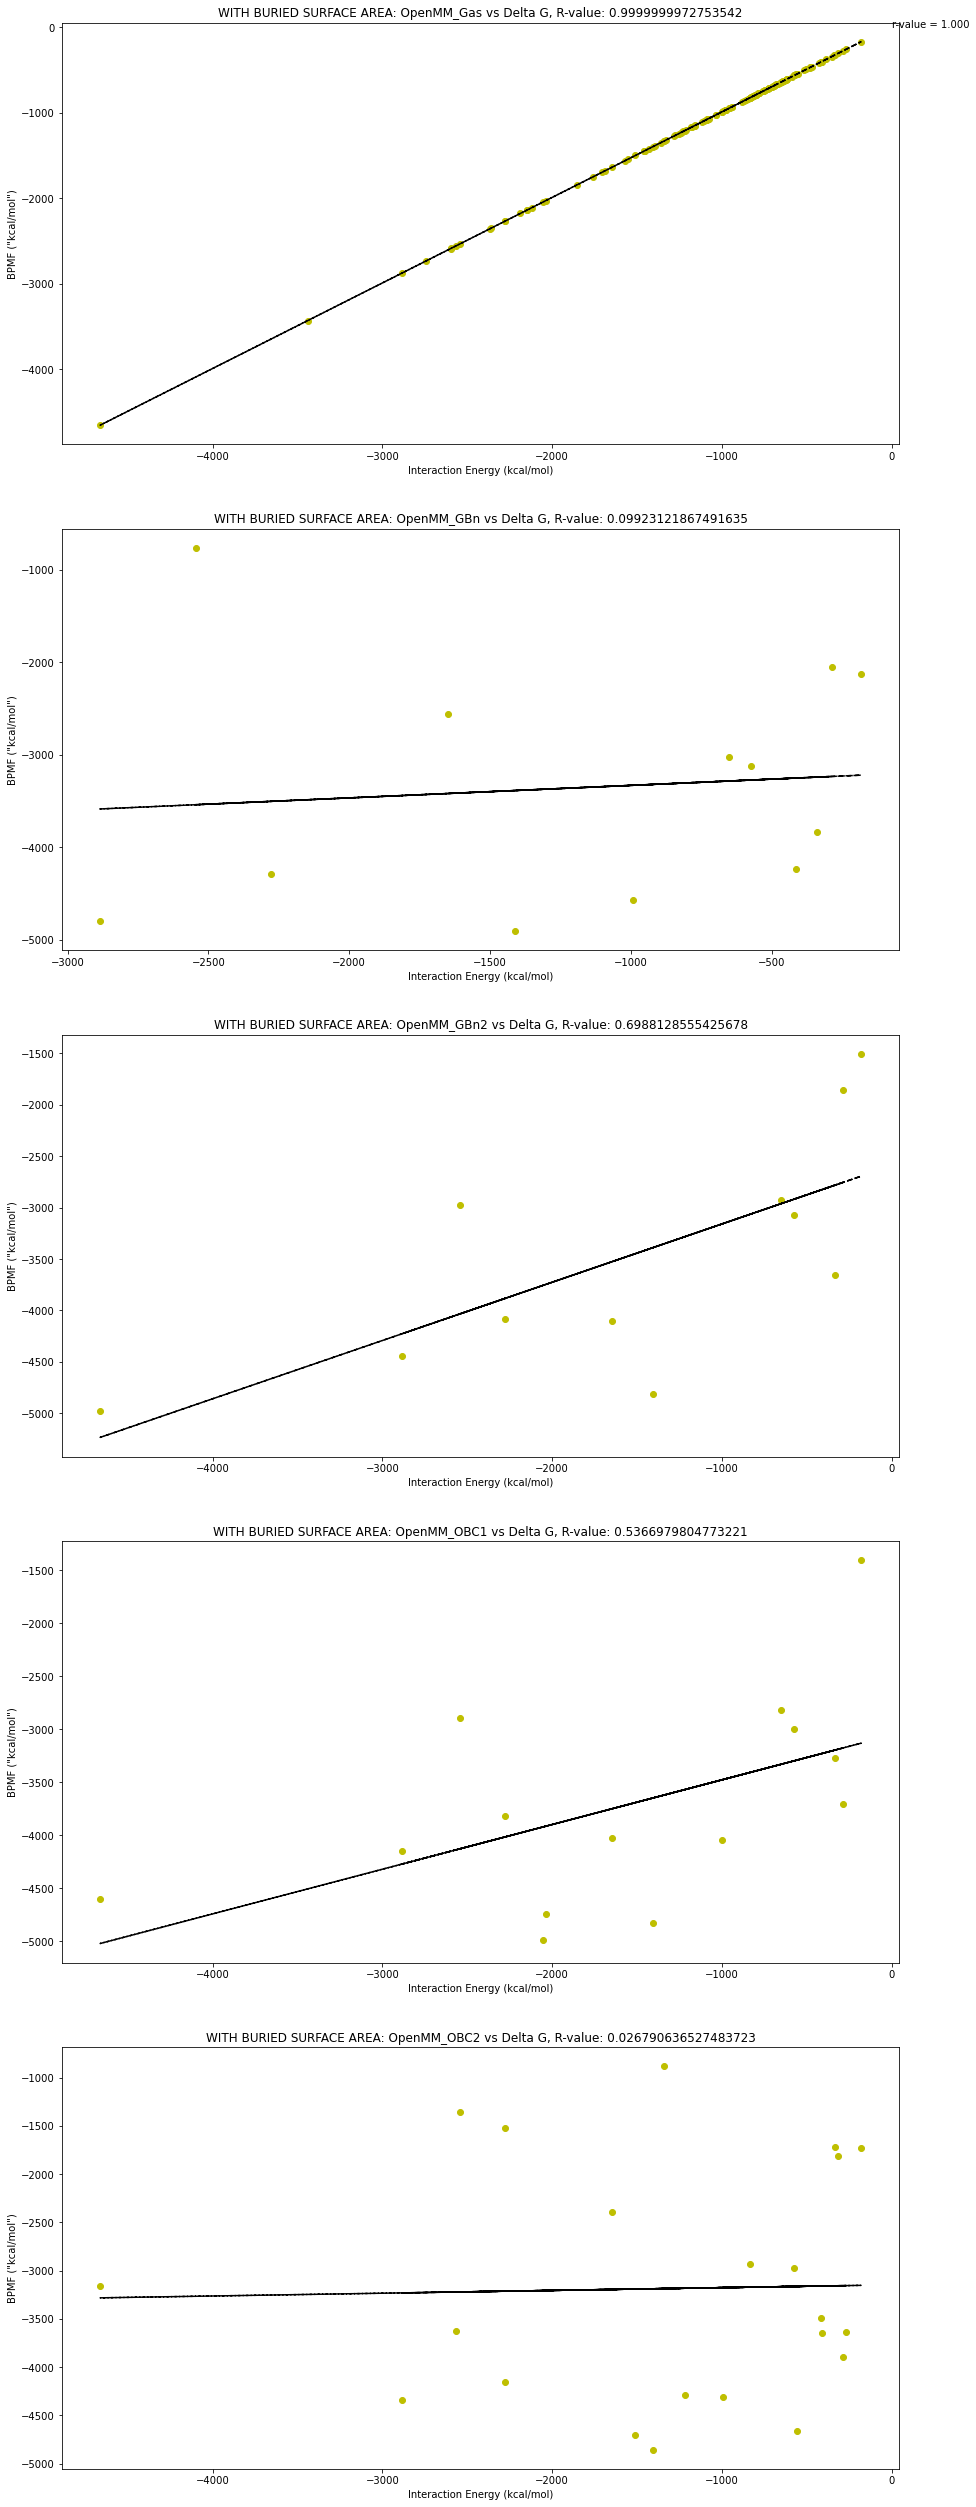

In [157]:
# BPMF vs Interaction energy
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pickle as p
import numpy as np
systems.sort()
models = ['OpenMM_Gas','OpenMM_GBn','OpenMM_GBn2','OpenMM_OBC1','OpenMM_OBC2']
affinity_bm = p.load( open( "/media/jim/Research_TWO/FFT_PPI/1.data_prep/1.affinity_database/affinity_bm.p", "rb" ))

bpmfs = {}
ie = []
for model in models:
    bpmfs[model] = []

for system_name in systems[:160]:
    # data = p.load( open(f'/media/jim/Research_TWO/OldData/6.postprocess/{system_name}/bpmf.pkl', 'rb'), encoding='latin1')
    try:
        data = p.load( open(f'/media/jim/Research_TWO/FFT_PPI/2.redock/6.postprocess/{system_name}/bpmf.pkl', 'rb'), encoding='latin1')
        fft_nc = nc.Dataset(f'/media/jim/Research_TWO/FFT_PPI/2.redock/5.fft_sampling/{system_name}/fft_sample.nc')
        lowest_ie = np.amin(fft_nc.variables['resampled_energies'])
        for model in models:
            bpmfs[model].append(data['bpmf'][model])
        ie.append(lowest_ie)
    except:
        print('failed loading file')
        for model in models:
            bpmfs[model].append(0)
        ie.append(np.amin(np.amin(fft_nc.variables['resampled_energies'])))

keys = list(bpmfs.keys())
ys = np.array(ie, dtype='float64')
fig, ax = plt.subplots(5,1)

for key in range(len(keys)):
    
    x = np.array(bpmfs[keys[key]])
    # x[x<-1500] = 0
    # x[np.isnan(x)] = 0
    # x[x>0] = 0
    y = ys
  
    outliers = np.where(x == 0)
    outliers = outliers[::-1]
    
    # for i in outliers:
    #     x = np.delete(x, i)
    #     y = np.delete(y, i)
    
    x = np.delete(x, 65)
    y = np.delete(y, 65)
    
    x = np.delete(x, 29)
    y = np.delete(y, 29)
    
    # for i in range(len(x)):
    #     print(systems[i],i,f'BPMF:{x[i]}',f'IE:{y[i]}')
    # print('')
    x[x<-5000] = 0
    # x[x>0] = 0
    outliers = np.where(x == 0)
    outliers = outliers[::-1]
    
    for i in outliers:
        x = np.delete(x, i)
        y = np.delete(y, i)
    
    ya = y
    xa = x
    y = xa
    x = ya
    reg = linregress(x,y)

    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef) 
    # poly1d_fn is now a function which takes in x and returns an estimate for y
    
    m,b = np.polyfit(x, y, 1)
    ax[key].plot(x,y, 'yo', x, poly1d_fn(x), '--k') #'--k'=black dashed line, 'yo' = yellow circle marker
    ax[key].annotate("r-value = {:.3f}".format(reg[2]**2), (0, 1))
    ax[key].set_title(f'WITH BURIED SURFACE AREA: {keys[key]} vs Delta G, R-value: ' + str(reg[2]))
    ax[key].set_ylabel("BPMF (\"kcal/mol\")")
    ax[key].set_xlabel("Interaction Energy (kcal/mol)")
    # print(f'********{keys[key]}*********')
    
fig.set_figheight(45)
fig.set_figwidth(15)
plt.savefig("BPMFvsIE_noBPMFunder5000.jpg", dpi=150)
plt.show()

(array([  6,  17,  20,  24,  26,  27,  29,  34,  41,  46,  47,  49,  50,
        51,  53,  55,  59,  60,  65,  67,  68,  76,  77,  98,  99, 102,
       106, 121, 125, 126, 130, 131, 132, 143, 147, 152, 162, 164, 175]),)
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  24,  25,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 109, 111, 114,
       120, 123, 126, 140, 145, 146, 150, 153, 157, 158, 173, 178]),)
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  24,  25

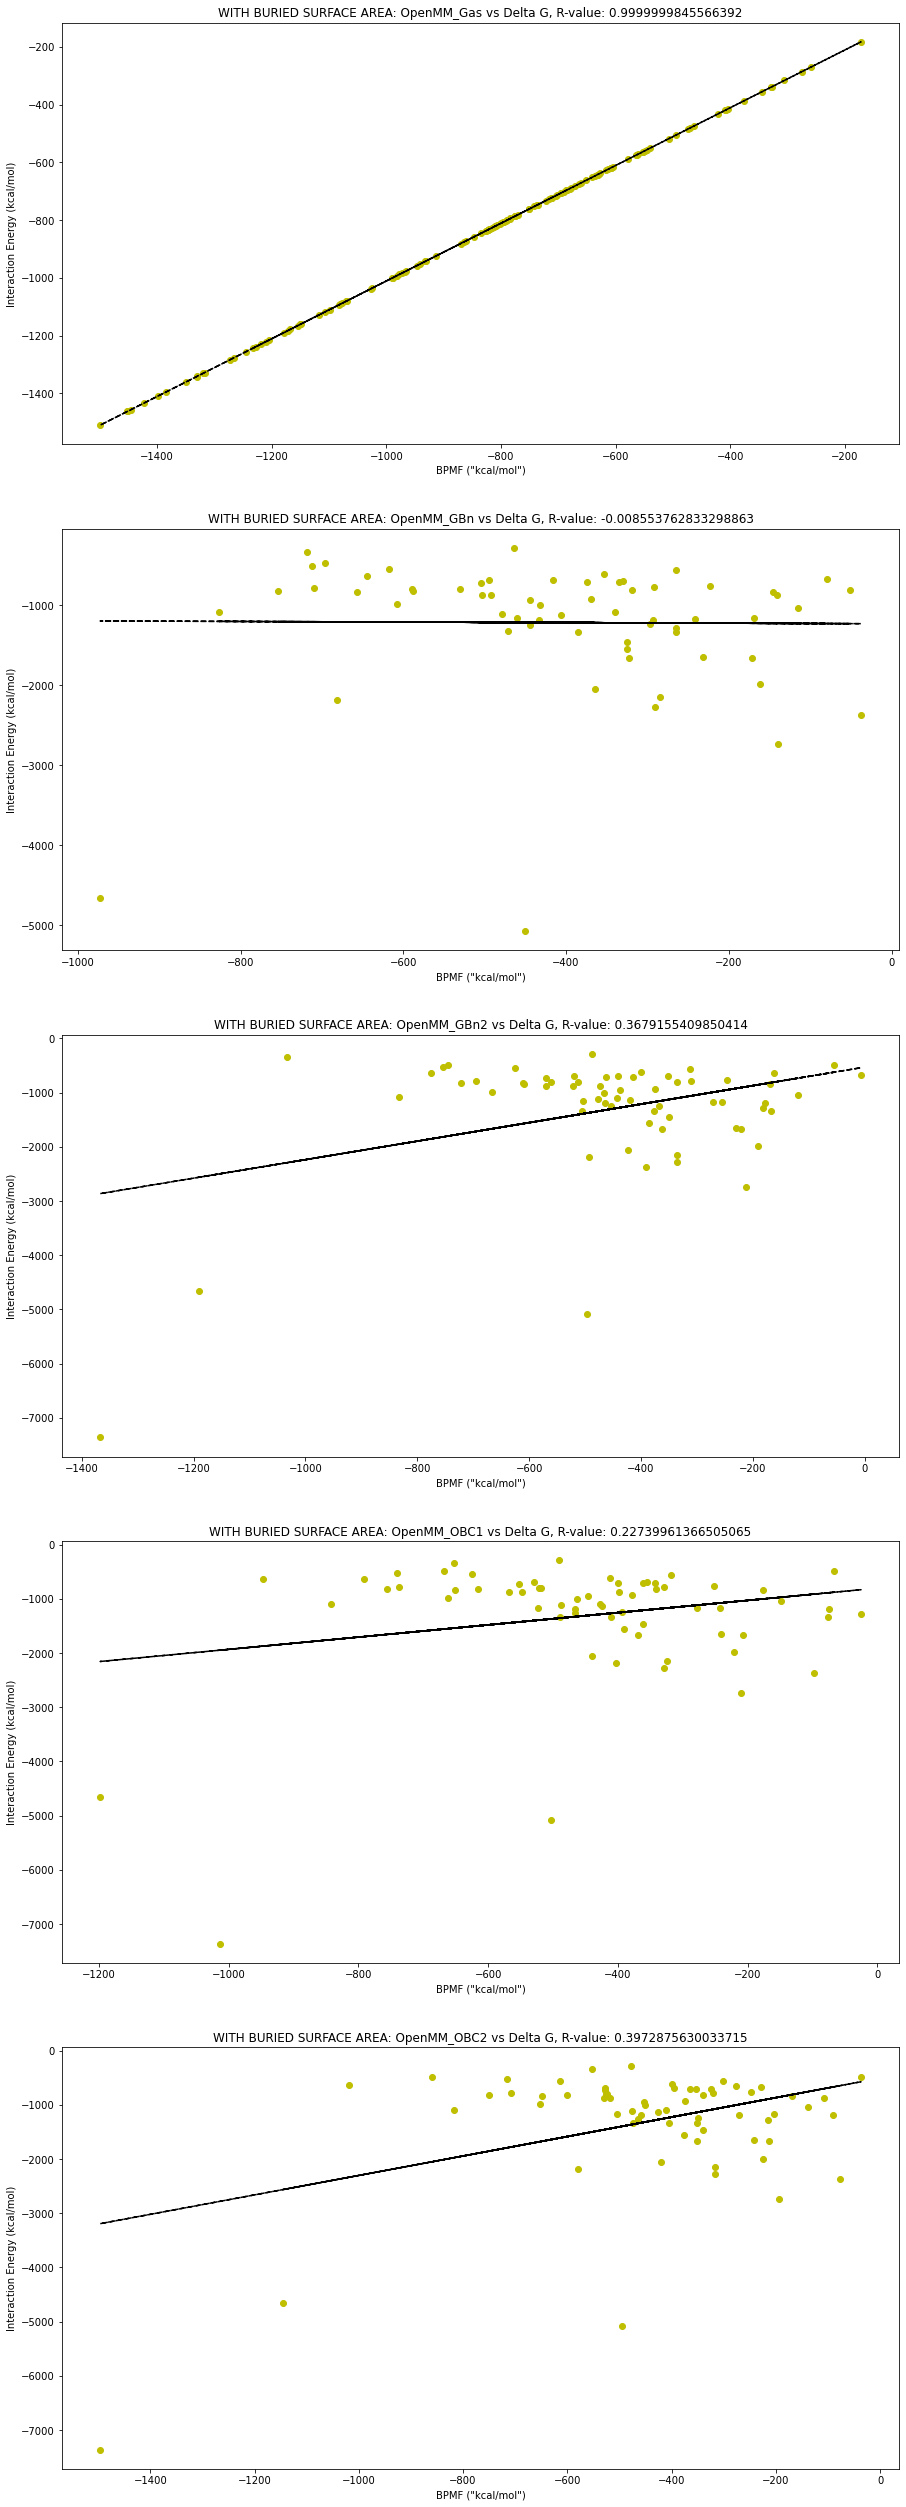

In [57]:
# Minimum IE vs Distance to Crystal pose
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pickle as p
systems.sort()
models = ['OpenMM_Gas','OpenMM_GBn','OpenMM_GBn2','OpenMM_OBC1','OpenMM_OBC2']
affinity_bm = p.load( open( "/media/jim/Research_TWO/FFT_PPI/1.data_prep/1.affinity_database/affinity_bm.p", "rb" ))

bpmfs = {}
ie = []
for model in models:
    bpmfs[model] = []

for system_name in systems:
    # data = p.load( open(f'/media/jim/Research_TWO/OldData/6.postprocess/{system_name}/bpmf.pkl', 'rb'), encoding='latin1')
    try:
        data = p.load( open(f'/media/jim/Research_TWO/FFT_PPI/2.redock/6.postprocess/{system_name}/bpmf.pkl', 'rb'), encoding='latin1')
        fft_nc = nc.Dataset(f'/media/jim/Research_TWO/FFT_PPI/2.redock/5.fft_sampling/{system_name}/fft_sample.nc')
        lowest_ie = np.amin(fft_nc.variables['resampled_energies'])
        for model in models:
            bpmfs[model].append(data['bpmf'][model])
        ie.append(lowest_ie)
    except:
        print('failed loading file')
        for model in models:
            bpmfs[model].append(0)
        ie.append(np.amin(np.amin(fft_nc.variables['resampled_energies'])))

keys = list(bpmfs.keys())
ys = np.array(ie, dtype='float64')
fig, ax = plt.subplots(5,1)

for key in range(len(keys)):
    
    x = np.array(bpmfs[keys[key]])
    x[x<-1500] = 0
    x[np.isnan(x)] = 0
    x[x>0] = 0
    y = ys
    outliers = np.where(x == 0)
    outliers = outliers[::-1]
    print(outliers)
    for i in outliers:
        x = np.delete(x, i)
        y = np.delete(y, i)
            
        
    reg = linregress(x,y)

    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef) 
    # poly1d_fn is now a function which takes in x and returns an estimate for y
    
    m,b = np.polyfit(x, y, 1)
    ax[key].plot(x,y, 'yo', x, poly1d_fn(x), '--k') #'--k'=black dashed line, 'yo' = yellow circle marker
    # ax[key].annotate("r2-value = {:.3f}".format(reg[2]**2), (0, 1))
    ax[key].set_title(f'WITH BURIED SURFACE AREA: {keys[key]} vs Delta G, R-value: ' + str(reg[2]))
    ax[key].set_xlabel("BPMF (\"kcal/mol\")")
    ax[key].set_ylabel("Interaction Energy (kcal/mol)")

fig.set_figheight(45)
fig.set_figwidth(15)
plt.savefig("BPMFvsIE.pdf", dpi=150)
plt.show()

In [10]:
y

array([], dtype=float64)

In [21]:
fft_nc = nc.Dataset(f'/media/jim/Research_TWO/FFT_PPI/2.redock/5.fft_sampling/2OOB_A:B/fft_sample.nc')

In [23]:
print(fft_nc.variables.keys())

dict_keys(['rec_positions', 'lig_positions', 'lig_com', 'volume', 'nr_grid_points', 'exponential_sums', 'log_of_divisors', 'mean_energy', 'min_energy', 'energy_std', 'resampled_energies', 'resampled_trans_vectors', 'lj_sigma_scaling_factor', 'x', 'y', 'z', 'd0', 'd1', 'd2', 'spacing', 'counts', 'origin', 'rec_core_scaling', 'rec_surface_scaling', 'rec_metal_scaling'])


In [42]:
y

array([ -9.31, -13.05, -11.55,  -6.43,  -5.32, -12.07, -12.5 ,  -6.55,
       -13.23,  -8.94, -11.55, -17.32,  -9.7 , -10.53, -15.06, -10.75,
        -9.78, -18.05, -11.67,  -7.87,  -8.28, -10.28,  -7.42, -14.06,
       -15.59, -10.12, -18.58,  -7.43, -13.77, -14.19,  -7.6 , -10.43,
        -8.09, -12.28,  -9.79, -13.12,  -6.51, -13.23,  -6.76, -11.32,
        -9.03, -11.3 , -10.2 ,  -9.18, -13.08,  -7.37, -10.76, -15.83,
        -7.46,  -9.76, -12.07, -10.42, -15.  ,  -8.13, -15.55,  -9.47,
       -13.64, -14.41, -12.82, -11.14, -12.77, -10.68, -10.02,  -7.28,
        -8.92, -12.34, -11.54,  -7.79, -11.24,  -7.45, -14.51,  -9.61,
        -7.53, -13.86, -11.02, -14.  ,  -7.43,  -7.8 , -11.19, -12.28,
       -11.32, -13.63, -15.56,  -9.52, -12.97,  -7.16, -14.17,  -8.84,
        -8.18, -13.86,  -4.29, -13.1 ,  -8.09, -18.  , -11.46, -12.72,
       -12.48,  -6.62,  -8.9 ,  -7.08, -11.18, -11.17,  -6.98,  -9.08,
       -12.04,  -8.03, -10.25, -11.67, -10.63,  -6.71, -12.11, -10.86,
      

In [43]:
x

array([ -1232.256898  ,   -822.722969  ,   -545.55782799,   -685.52021051,
        -1450.4684184 ,   -463.14079118,  -1845.4275492 ,   -712.51425622,
         -305.55485433,   -631.5167694 ,   -982.12983383,  -1171.95993584,
         -578.94830047,   -616.14914825,   -695.34990954,   -493.82559268,
        -1384.17959258,  -3428.24750843,  -1027.66828724,  -1068.73118882,
        -2110.91681246,   -742.05364091,   -932.15153875,  -1273.36058152,
        -2554.90674298,  -1209.93841799,  -2177.47746277,  -2585.67400413,
        -1148.62399514,             nan,   -329.32907816,   -775.06152561,
         -408.44993848,   -564.33721371,  -5119.29447074,   -774.90833037,
         -563.40032772,   -636.5129229 ,   -171.83768517,  -1265.67546944,
         -946.84266334,  -1679.23003221,   -608.30797712,   -967.31365865,
        -1349.63474054,   -560.38452358,  -1696.57985542,  -2873.81601787,
         -794.83897172,  -1562.93834845,  -7349.71208464,  -2266.93994481,
        -1218.89886007, -

In [8]:
import pickle as p
native_translations = p.load( open( "/media/jim/Research_TWO/FFT_PPI/2.redock/4.receptor_grid/native_translations.p", "rb" ) )
print(native_translations['2OOB_A:B'])

{'crd': array([34. , 43.5, 22.5]), 'grid': masked_array(data=[68.0, 87.0, 45.0],
             mask=[False, False, False],
       fill_value=1e+20)}


In [11]:
import numpy as np
arr_1 = np.array([True, True, False, False])
arr_2 = np.array([False, False, True, True])
arr_3 = arr_1 + arr_2
print(arr_3)

[ True  True  True  True]


In [16]:
arr_4 = np.array([1000, 1000, 0, -1000])
free = (arr_4 < 0) + (arr_4 > 50)

In [17]:
print(free)

[ True  True False  True]
